In [1]:
import numpy as np
from scipy.spatial.transform import Rotation as R
import utils
import nonholonomic_dmps as nhdmp

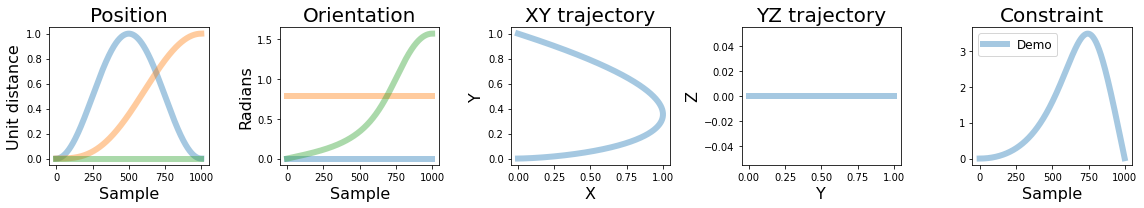

In [2]:
# Generate the demonstration of pose trajectory
N = 1000
dt = 0.001

x_demo = (np.sin(1*np.pi*np.linspace(0,1,N)))**2
y_demo = (np.sin(0.5*np.pi*np.linspace(0,1,N)))**3
z_demo = np.zeros(x_demo.shape[0])
yaw_demo =  np.arctan2(y_demo,x_demo) # heading angle
roll_demo = np.zeros(x_demo.shape[0]) # no roll
pitch_demo = np.ones(x_demo.shape[0]) * np.pi / 4.0

# End-effector position
xyz_demo = np.vstack((x_demo,y_demo,z_demo)).T
dxyz_demo = np.gradient(xyz_demo,axis=0)/dt
ddxyz_demo = np.gradient(dxyz_demo,axis=0)/dt

# End-effector orientation
q_demo = np.zeros([N,4])
for i in range(N):
    q_demo[i,:] = R.from_euler('xyz',[roll_demo[i],pitch_demo[i],yaw_demo[i]]).as_quat()

w_demo = utils.quaternion_diff(q_demo,dt)
dw_demo = np.gradient(w_demo,axis=0)/dt

# Evaluate the constraint violation by demo
constraint_demo = []
for i in range(0,N):
    constraint_demo.append(utils.nonholonomic_constraint_equation(dxyz_demo[i,:],q_demo[i,:]))

# Plot demo trajectories and constraint
utils.plot_rollout(xyz_demo,R.from_quat(q_demo).as_euler('xyz'),constraint_demo,label='Demo')

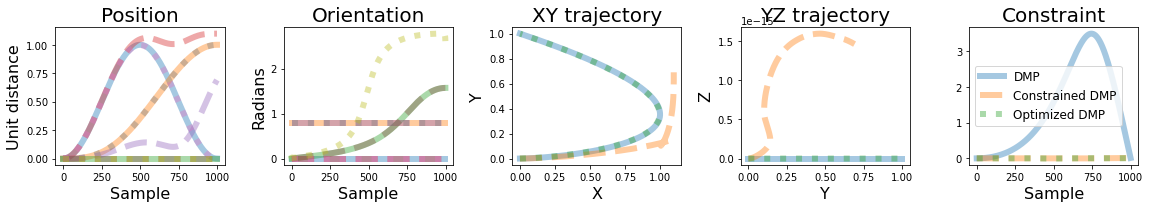

In [3]:
# Fit the Non-holonomic DMP
dmp = nhdmp.NonholonomicDMP(N_bf=100,alphaz=25,betaz=6.25,dt=dt)
_, _, _, _, _, _ = dmp.imitate(np.hstack((xyz_demo,q_demo)))

# Rollout w/ and w/o optimization step
xyz_con, _, _, q_con, _, _, constraint_con, _ = dmp.rollout(con=True,optim=False) # w/o optimization
xyz_opt, _, _, q_opt, _, _, constraint_opt, _ = dmp.rollout(con=True,optim=True) # with optimization


# Plot the DMP trajectories
utils.plot_rollout([xyz_demo,xyz_con,xyz_opt], 
             [R.from_quat(q_demo).as_euler('xyz'),
              R.from_quat(q_con).as_euler('xyz'),
              R.from_quat(q_opt).as_euler('xyz')],
             [constraint_demo,constraint_con,constraint_opt], 
             label=['DMP','Constrained DMP','Optimized DMP'])

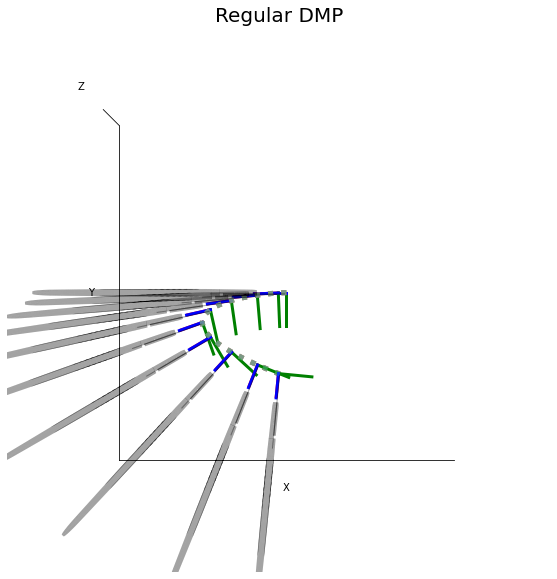

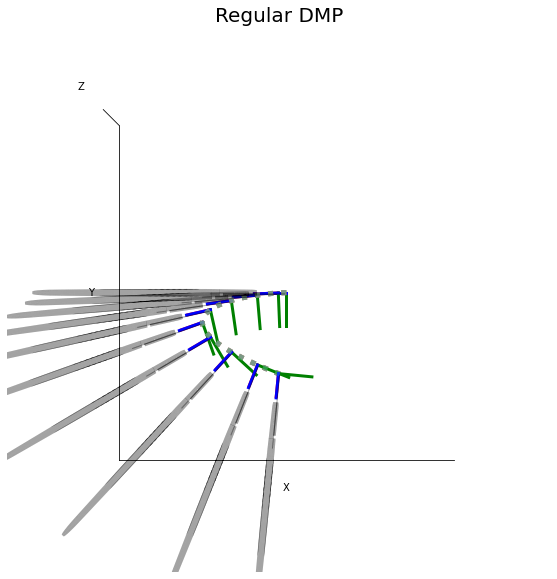

In [4]:
# Replay the demonstration
pose_traj = np.hstack((xyz_demo,q_demo))
utils.scalpel_trajectory(pose_traj,skip_frames=100, elevation=90, title='Regular DMP')

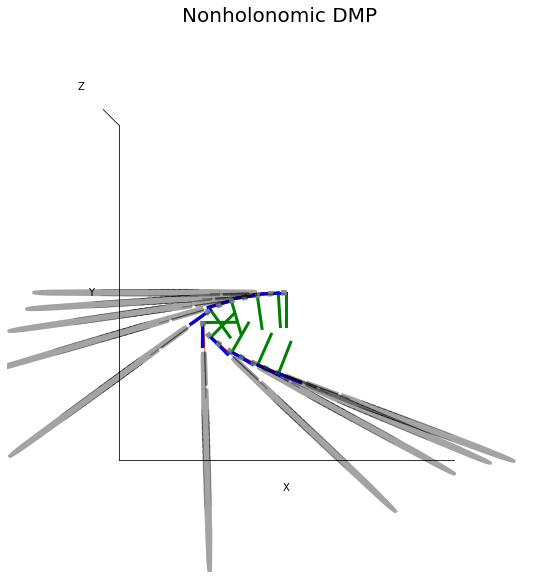

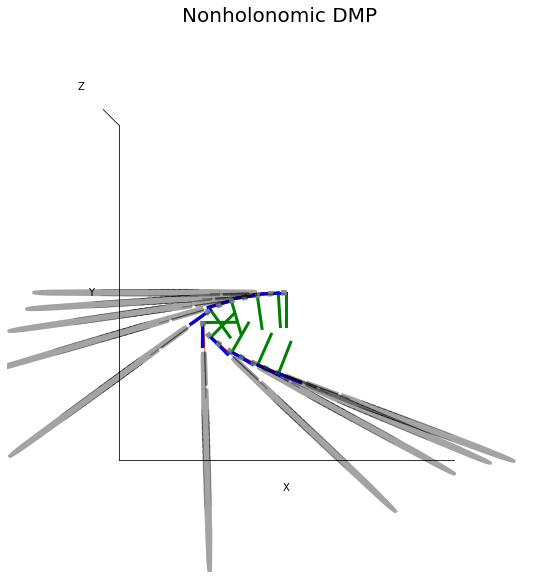

In [5]:
# Replay Nonholonomic DMP
pose_traj = np.hstack((xyz_opt,q_opt))
utils.scalpel_trajectory(pose_traj,skip_frames=100, elevation=90, title='Nonholonomic DMP')